In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import sys
sys.path.append('./scripts/')
from tqdm import tqdm

import patsy
import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Logit

import matplotlib.pyplot as plt

# Extended Figure 4c

In [21]:
df = pd.read_csv('./source-data/bench_gnomad_AF.txt', sep='\t', low_memory=False)
df.drop(columns=['boostDM_score'], inplace=True)

In [22]:
df['AF_bin'] = df['FUNC_SCORE'].apply(lambda x: 1*(0<=x<1e-5) + 2*(1e-5<=x<1e-4) + 3*(1e-4<=x<1e-3) + 4*(1e-3<=x))
df = df[df['FUNC_SCORE'] > 0]  # keep non-zero frequencies
df['logAF'] = df['FUNC_SCORE'].apply(lambda x: -np.log10(x))

In [34]:
def logit(gene, ttype):
    
    dg = df[(df['gene'] == gene) & ((df['csqn_type_missense'] == 1) | (df['csqn_type_nonsense'] == 1))].copy()
    dg[f'boostDM_score_{ttype}_bin'] = dg[f'boostDM_score_{ttype}'].apply(lambda x: int(x >= 0.5))
    y, X = patsy.dmatrices(f'boostDM_score_{ttype}_bin ~ logAF', dg, return_type='matrix')
    logit = Logit(y, X)
    res = logit.fit_regularized(method='l1', disp=0)
    return res._results.params, res._results.pvalues


def plot_gnomad_bar(gene, ttype, plot=False):
    
    dg = df[(df['gene'] == gene) & ((df['csqn_type_missense'] == 1) | (df['csqn_type_nonsense'] == 1))]
    dg = dg.drop_duplicates(subset=['chr', 'pos', 'alt', 'aachange'], keep='first')
    x = dg['AF_bin'].values + np.random.normal(0, 0.03, size=dg['AF_bin'].shape[0])
    y = dg[f'boostDM_score_{ttype}'].values
    
    # logistic regression
    params, pvalues = logit(gene, ttype)
    
    # boostDM bins
    bins = []
    for b in [1,2,3,4]:
        bins.append(dg[dg['AF_bin'] == b][f'boostDM_score_{ttype}'].values)
    
    driver_bin = list(map(lambda x: sum(x >= 0.5) / len(x), bins))
    passenger_bin = list(map(lambda x: sum(x < 0.5) / len(x), bins))
    
    if plot:
        fig, ax = plt.subplots()
        ax.bar([1,2,3,4], driver_bin, color='#ac0f0f', width=0.5, alpha=0.7)
        ax.bar([1,2,3,4], passenger_bin, bottom=driver_bin, width=0.5, color='#636363', alpha=0.5)
        ax.set_xticks([1,2,3,4])
        xticklabels = ['$\leq 10^{-5}$', '$10^{-5}-10^{-4}$', '$10^{-4}-10^{-3}$', '$\geq 10^{-3}$']

        ax.set_xticklabels(xticklabels)
        ax.set_title(f'{gene}: {ttype}\nLOR={params[1]:.3f}: pval={pvalues[1]:.3f}')
        ax.set_ylabel('boostDM')
        ax.set_xlabel('frequency bins (gnomAD)')
        ax.set_ylim(-0.1, 1.19)
        for b in [1,2,3,4]:
            ax.annotate(f'N={int(driver_bin[b-1] * len(bins[b-1]))}/{len(bins[b-1])}', (b-0.2, 1.1))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        plt.savefig(f'./raw_plots/{gene}.{ttype}.gnomad.bar.png', dpi=300, bbox_inches='tight')
        plt.show()

    return params[1], pvalues[1], len(x)

In [35]:
# individual plots and logistic regressions gene-wise

res = {}
boostdm_scores = [c for c in df.columns if c.startswith('boostDM_score')]
for s in boostdm_scores:
    dg = df[~df[s].isnull()]
    res[s] = dg['gene'].unique().tolist()

logoddsratios = []
pvalues = []
sizes = []
labels = []

for score, genes in tqdm(res.items()):
    for g in genes:
        ttype = '_'.join(score.split('_')[2:])
        try:
            lor, pval, n = plot_gnomad_bar(g, ttype)
            if abs(lor) < 5:
                logoddsratios.append(lor)
                pvalues.append(pval)
                sizes.append(n)
                labels.append(f'{g} ({ttype})')
        except Exception as e:
            print(g, ttype, e)

  3%|▎         | 1/37 [00:00<00:24,  1.49it/s]

KRAS ST division by zero
SPOP PRAD division by zero
PTEN PRAD division by zero


  5%|▌         | 2/37 [00:01<00:25,  1.35it/s]

HRAS HNSC division by zero


 11%|█         | 4/37 [00:05<00:44,  1.35s/it]

RHOA BLCA division by zero
KRAS BLCA division by zero


 16%|█▌        | 6/37 [00:09<00:49,  1.59s/it]

PTEN UCEC division by zero


 19%|█▉        | 7/37 [00:09<00:35,  1.18s/it]

PTEN BRCA division by zero


 22%|██▏       | 8/37 [00:10<00:30,  1.05s/it]

PTEN COREAD division by zero
KRAS COREAD division by zero


 24%|██▍       | 9/37 [00:11<00:28,  1.02s/it]

PTEN GBM division by zero


 27%|██▋       | 10/37 [00:12<00:28,  1.04s/it]

KRAS LUNG_CANCER division by zero


 32%|███▏      | 12/37 [00:16<00:38,  1.53s/it]

KRAS LUAD division by zero


 41%|████      | 15/37 [00:20<00:33,  1.53s/it]

PTPN11 AML division by zero


 43%|████▎     | 16/37 [00:21<00:25,  1.21s/it]

NRAS AML division by zero


 46%|████▌     | 17/37 [00:21<00:19,  1.02it/s]

NRAS MM division by zero
KRAS MM division by zero


 57%|█████▋    | 21/37 [00:22<00:07,  2.24it/s]

SF3B1 CLL division by zero


 59%|█████▉    | 22/37 [00:22<00:06,  2.45it/s]

KRAS PAAD division by zero


 65%|██████▍   | 24/37 [00:23<00:04,  2.66it/s]

KRAS CH division by zero


 70%|███████   | 26/37 [00:23<00:02,  3.79it/s]

KRAS OV division by zero


 81%|████████  | 30/37 [00:30<00:08,  1.15s/it]

PTEN CM division by zero


 84%|████████▍ | 31/37 [00:33<00:10,  1.77s/it]

NRAS CM division by zero


 89%|████████▉ | 33/37 [00:33<00:03,  1.02it/s]

PTEN R division by zero


 92%|█████████▏| 34/37 [00:34<00:02,  1.13it/s]

PBRM1 R division by zero
HRAS THCA division by zero


 95%|█████████▍| 35/37 [00:35<00:01,  1.30it/s]

NRAS THCA division by zero
NRAS ALL division by zero


 97%|█████████▋| 36/37 [00:35<00:00,  1.55it/s]

KRAS ALL division by zero


100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


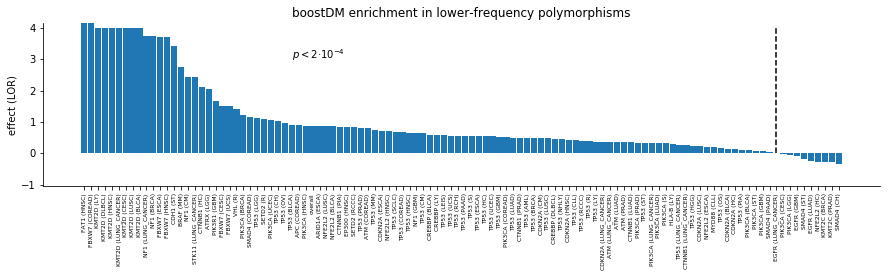

In [36]:
figsize = (15,3)
fig, ax = plt.subplots(figsize=figsize)

sortindex = np.argsort(logoddsratios + [0.86])[::-1]
lor = np.array(logoddsratios + [0.86])[sortindex]
lab = np.array(labels + ['overall'])[sortindex]

ax.bar(range(len(lor)), lor, width=0.9)

ax.text(30, 3, '$p<2·10^{-4}$')

ax.vlines(100, 0, 4, linestyles='--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(len(lor)))
ax.set_xticklabels(lab, fontsize=6, rotation=90)
ax.set_ylabel('boostDM model')
ax.set_ylabel('effect (LOR)')
ax.set_ylim(-1.05, 4.15)
ax.set_title('boostDM enrichment in lower-frequency polymorphisms')
plt.savefig('./raw_plots/bar.effect.gnomad.svg', dpi=300, bbox_inches='tight')
plt.show()